In [2]:
import jax.numpy as jnp #jax numpy
import jax #other jax functions used
from tqdm import tqdm #for nice bars

import optax  # Optimizer library

import time # to set random seeds
from functools import partial #needed to @jax.jit over only some params

import numpy as np #used with manim

# Physics Simulation

In [3]:
#---GLOBAL CONSTANTS FOR THE CREATURE---

#--FRICTION STUFF--
# Friction forces apply according to mu*g*M where M is the mass of creature 
g = 10 #gravity constant. 
mu_static = 0.25 #static friction coefficent. 
mu_kinetic = 0.15 #kinetic friction coefficent

#--Mass Stuff--
M_min = 1.0 #minimum mass on each vertex
M_total = 15.0 #total mass of the creature #M_max = M_total - 2*M_min if you want!
# The creature weighs M_total across its 3 legs, 
# but must always have >= M_min mass on each leg at any time
K_mass = 4.0 #pump constant for the masses
# The creature pumps mass according to dM/dt = K(M - M_eq) where M_eq is the equlibrium mass it is aiming for

#--Muscles Spring Stuff--
L_min = 1.6 #minimum spring eq lenth, when muscle = 0
L_max = 2.8 #maximum spring eq length, when muscle = 1
K_spring = 9.0 #spring constant F = K(L - L_eq) 

#--Simulation Timestep--
dt = 0.1 #timestep for 1 phyics iteration


@jax.jit
def calculate_forces(info):
    #Calcualtes the forces on the three vertices due to
    # 1. Spring forces
    # 2. Friction
    # Returns the force on each vertex in Shape (batch_size,3,2)
    positions, velocities, masses, pumps, muscles = info
    #Shapes of things:
    # Vertex Indexed Things:
    #   positions (batch_size, 3, 2)
    #   velocities (batch_size, 3, 2)
    #   masses (batch_size, 3)
    #   pumps (batch_size, 3)
    #     [0,1] valued where 0 represents max shrink, 1 represent max grow
    # Edge indexed things: Edge Order 01, 02, 12
    #   muscles (batch_size, 3)
    #     [0,1] valued  where 0 represents minimum lenght, 1 represents max length


    ###--EDGE STUFF--

    # Compute edge vectors for all triangles in the batch
    edge_01 = positions[..., 1, :] - positions[..., 0, :]  # Vector from point 0 to point 1
    edge_02 = positions[..., 2, :] - positions[..., 0, :]  # Vector from point 0 to point 2
    edge_12 = positions[..., 2, :] - positions[..., 1, :]  # Vector from point 1 to point 2

    # Compute the current lengths of the edges
    length_01 = jnp.linalg.norm(edge_01, axis=-1)  # Shape: (batch_size,)
    length_02 = jnp.linalg.norm(edge_02, axis=-1)  # Shape: (batch_size,)
    length_12 = jnp.linalg.norm(edge_12, axis=-1)  # Shape: (batch_size,)

    # Normalize edge vectors to get unit directions.
    # make sure lengths are at least epsilon to aviod diveisoon by zero
    epsilon = 1e-8
    dir_01 = edge_01 / jnp.maximum(length_01[..., None],epsilon)  # Shape: (batch_size, 2)
    dir_02 = edge_02 / jnp.maximum(length_02[..., None],epsilon)  # Shape: (batch_size, 2)
    dir_12 = edge_12 / jnp.maximum(length_12[..., None],epsilon)  # Shape: (batch_size, 2)

    # Compute spring forces based on Hooke's law: F = -K * (L - L_eq) * direction

    edge_lengths_eq = L_min + muscles*(L_max - L_min) #equilbirum lengths based on muscle status

    s_force_01 = -K_spring * (length_01 - edge_lengths_eq[..., 0])[..., None] * dir_01  # Shape: (batch_size, 2)
    s_force_02 = -K_spring * (length_02 - edge_lengths_eq[..., 1])[..., None] * dir_02  # Shape: (batch_size, 2)
    s_force_12 = -K_spring * (length_12 - edge_lengths_eq[..., 2])[..., None] * dir_12  # Shape: (batch_size, 2)

    # Initialize forces tensor for all vertices
    # forces is indexed by the vertices now.
    forces = jnp.zeros_like(positions)  # Shape: (batch_size, 3, 2)

    # Accumulate spring forces for each vertex
    forces = forces.at[..., 0, :].add(-s_force_01 - s_force_02)  # Point 0 affected by edges 01 and 02
    forces = forces.at[..., 1, :].add(s_force_01 - s_force_12)   # Point 1 affected by edges 01 and 12
    forces = forces.at[..., 2, :].add(s_force_02 + s_force_12 )   # Point 2 affected by edges 02 and 12

    ###--FRICTION FORCES--
    # Compute the magnitudes of the velocities for each vertex in the batch
    speed = jnp.linalg.norm(velocities, axis=-1)  # Shape: (batch_size, 3)

    # Determine if each vertex is static (velocity near zero)
    static_epsilon = 1e-8
    is_static = (speed < static_epsilon)  # Shape: (batch_size, 3)
    velocity_directions = jnp.where( is_static[...,None], 0.0, velocities / speed[..., None])  # Safe divide by numbers close to zero. Shape: (batch_size, 3, 2)

    # Compute the magnitudes of the external forces
    force_magnitudes = jnp.linalg.norm(forces, axis=-1)  # Shape: (batch_size, 3)

    # Compute the maximum static friction force magnitudes
    static_friction_max = mu_static * masses * g  # Shape: (batch_size, 3)

    # Compute the kinetic friction force magnitudes
    kinetic_friction_magnitudes = mu_kinetic * masses * g  # Shape: (batch_size, 3)

    # Figure out which vertices have a "low" amount of force and are at rest
    # "low" means less than the maximum force static friction provides
    low_force_and_not_moving = jnp.logical_and(is_static, (force_magnitudes <= static_friction_max) )
    # Shape: (batch_size, 3) 
    
    forces = jnp.where( low_force_and_not_moving[...,None] , #setup so it can be broadcast with forces
                     0.0, #if low force & not moving, then set force to zero by static friction
                     #otherwise apply kinetic friction in direction opposite velocity)
                     forces - kinetic_friction_magnitudes[..., None] * velocity_directions   )

    return forces

@jax.jit
def triangle_update(iter_num, info):
  #Applies one time step, of time dt, to the positions, velocities, masses of the triangle creature
  #Setup so that it can work with jax.lax for loops for efficnency. iter_num is never used

    positions, velocities, masses, pumps, muscles = info
    #Shapes:
    # Vertex Indexed Things:
    #   positions (batch_size, 3, 2)
    #   velocities (batch_size, 3, 2)
    #   masses (batch_size, 3)
    #   pumps (batch_size, 3)
    #     [0,1] valued where 0 represents max shrink, 1 represent max grow
    # Edge indexed things: Edge Order 01, 02, 12
    #   muscles (batch_size, 3)
    #     [0,1] valued  where 0 represents minimum lenght, 1 represents max length


    # Second-Order Runge-Kutta Method (RK2 - Midpoint Method)
    # -------------------------------------------------------
    # 1. Compute acceleration at the initial position and velocity.
    # 2. Estimate velocity and position at the midpoint using half a time step.
    # 3. Compute acceleration at this midpoint.
    # 4. Use the midpoint acceleration to update velocity and position for the full step.
    # - Requires 2 acceleration function calls per step.
    # - Global error is O(dt^2), making it much more accurate than Forward Euler (O(dt)).

    
    #Convert "pumps" to fractions, e.g. 0,1,1 -> 0,1/2,1/2. epsilon is there so that (0,0,0) -> (1/3,1/3,1/3)
    #this has the property that all entries are in [0,1] and they sum to 1.
    epsilon = 1e-6
    pumps_fraction = (pumps + epsilon) / jnp.sum( pumps+epsilon, axis=-1, keepdims=True  )

    #Compute equilbrium mass amounts by distributing available weight by pump fractions
    masses_eq = M_min + pumps_fraction * (M_total - 3.0*M_min)  
  
    # RK2 method starts here
  

    #--Intial Calculations
    forces = calculate_forces((positions, velocities, masses, pumps, muscles))
    accelerations = forces / masses[..., None]  # Shape: (3, 2)
        
    #--Halfway point calculations
    masses_half = masses + (masses - masses_eq)*jnp.expm1(-K_mass*0.5*dt)
    #note expm1 is the function exp(x)-1.
    #This formula is the exact solution do dm/dt = K(m - m_eq) at time 0.5*dt

    positions_half = positions + 0.5*dt*velocities #halfway position estimate
    velocities_half = velocities + 0.5*dt*accelerations #halfway velocity estimate

    forces_half = calculate_forces((positions_half, velocities_half, masses_half, pumps, muscles))
    accelerations_half = forces_half / masses_half[..., None]  # Shape: (3, 2)

    #--Final calcualtions by using the midpoint
    masses_final = masses + (masses - masses_eq)*jnp.expm1(-K_mass*dt) #exact solution 
    positions_final = positions+dt*velocities_half #estimate using midpoint velocity
    velocities_final = velocities+dt*accelerations_half #estimate using midpoint accelerations
    
    #Note pumps, muscles are unchanged, but leave them in for easy use in jax.lax for loops
    return positions_final, velocities_final, masses_final, pumps, muscles

# Neural Netowrk Brain


In [4]:
# Define a simple fully connected neural network (FCNN) with ReLU activations

def init_params(key, input_size, hidden_size, output_size):
    """Initialize network parameters (weights and biases)"""
    # Weights and biases for the first layer (input to hidden)
    key, subkey = jax.random.split(key)
    W1 = jax.random.normal(subkey, (input_size, hidden_size)) * 0.1
    b1 = jnp.zeros(hidden_size)

    # Weights and biases for the second layer (hidden to output)
    key, subkey = jax.random.split(key)
    W2 = jax.random.normal(subkey, (hidden_size, hidden_size)) * 0.01
    b2 = jnp.zeros(hidden_size)

    # Weights and biases for the second layer (hidden to output)
    key, subkey = jax.random.split(key)
    W3 = jax.random.normal(subkey, (hidden_size, output_size)) * 0.01
    b3 = jnp.zeros(output_size)
    
    return (W1, b1, W2, b2, W3, b3) 

@jax.jit
def relu(x):
    """ReLU activation function"""
    return jnp.maximum(0, x)

@jax.jit
def forward(params, x):
    """Feedforward function. Returns the log probs"""
    W1, b1, W2, b2, W3, b3 = params
    first = jnp.dot(x, W1) + b1
    hidden = relu(jnp.dot(first,W2) + b2)  # Hidden layer with ReLU
    output = jnp.dot(hidden,W3) + b3

    log_probs = jax.nn.log_softmax(output, axis=-1)  # get the log probs
    return log_probs


#this function not used in current implentation....
@jax.jit
def lengths(points):
    # Define the edge pairs using indices
    edge_indices = jnp.array([[1, 0], [2, 0], [2, 1]])  # Edge pairs: [1,0], [2,0], [2,1]

    # Compute edge vectors by using the indices to select the points
    edges = points[..., edge_indices[:, 0], :] - points[..., edge_indices[:, 1], :]  # Shape: (batch_size, 3, 2)

    # Compute the magnitudes of the edges
    lengths = jnp.linalg.norm(edges, axis=-1)  # Shape: (batch_size, 3)
    return lengths

@jax.jit
def normalize_points(points):
    # given the vertices of a triangle return their relative positions by subtracting off the centroid
    centroid = jnp.mean(points, axis=-2, keepdims=True)  # Shape: (batch_size, 1, 2)
    normalized_points = points - centroid 
    return normalized_points

input_size = 15 # Flattened size of vertices, lengths and vertex masses
@jax.jit
def get_input(my_points, my_velocities, my_masses, my_pumps, my_muscles): 
    #This is the input to the neural network it consits of 15 numbers:
    # First 3 entires: y-coordinates of the points (so it can know how far up/down it is)
    # Next 3 entries: Relative x-coorindates of poitns (so it can know which of its feet are left/right)
    # Next 3 entries: Rleative y-coordinattes of points (so it can know which of its feet are up/down)
    # Next 3 pumps 
    # Next 3 muscles 
    return jnp.concatenate([my_points[...,1],normalize_points(my_points)[...,0],normalize_points(my_points)[...,1],my_pumps, my_muscles],axis=-1)

### -- Setup and test the neural network

key = jax.random.PRNGKey(int(time.time()))
hidden_size = 32 
output_size = 64-8  # 64 possible combinations for my_pumps and my_muscles
#-8 so that it does not ever use the state where all pumps are set to +1 (thats the same as setting them all to 0)

# Initialize network parameters
params = init_params(key, input_size, hidden_size, output_size)

#initial velocity and masses
my_velocities_init = jnp.zeros( (3,2) )
my_masses_init = jnp.array([1.0,1.0,1.0])*(M_total)/3.0 #jnp.array([5.0,5.0,5.0])
my_points_init = jnp.array([
    [-1.0, 0.0],   # First vertex
    [1.0, 0.0],    # Second vertex
    [0.0, 1.732]  # Third vertex
]) #1.732 = sqrt(3)

#example points
my_muscles = jnp.array([0.0,1.0,0.0])
my_pumps = jnp.array([1.0,1.0,0.0])

# Initialize simulation data
my_points = my_points_init
my_velocities = my_velocities_init
my_masses = my_masses_init


### test to see if the network is working

inputs = get_input(my_points, my_velocities, my_masses, my_pumps, my_muscles)
log_probs = forward(params, inputs) #outputs the log probs directly
print("Output probability distribution over {output_size} tokens:", log_probs)


Output probability distribution over {output_size} tokens: [-4.0259724 -4.0260606 -4.0256686 -4.0243673 -4.0255656 -4.0253673
 -4.0252028 -4.0254292 -4.025243  -4.0242777 -4.02479   -4.023657
 -4.025037  -4.0252833 -4.024951  -4.0260377 -4.025917  -4.0251493
 -4.0258207 -4.0243235 -4.0255165 -4.0258737 -4.0248876 -4.026269
 -4.026057  -4.0252857 -4.0248914 -4.025167  -4.0258822 -4.0246477
 -4.0246067 -4.027581  -4.0246997 -4.0259767 -4.026132  -4.0244966
 -4.02542   -4.0248632 -4.0267467 -4.0248632 -4.023719  -4.025655
 -4.0267935 -4.0251355 -4.024152  -4.025514  -4.0255494 -4.025466
 -4.0259337 -4.0260553 -4.026952  -4.024781  -4.0251684 -4.0251293
 -4.0253654 -4.024349 ]


# RL Helper Functions

In [5]:
@jax.jit
def compute_reward_score(my_points):
    """
    Computes the raw reward of a set of points 
    """
    # Compute the x-coordinate of the centroid by averaging the x-coordinates of the 3 vertices
    centroid_x = jnp.mean(my_points[..., 0], axis=-1)  # Shape: (batch_size,)
    centroid_y = jnp.mean(my_points[..., 1], axis=-1)  # Shape: (batch_size,)

    return centroid_x - jnp.abs(centroid_y)

@jax.jit
def sample_action(key, logits, temperature=1.0):
    """ sample an action according to given logits and temperature"""

    # Apply temperature scaling
    scaled_logits = logits / temperature

    # Sample actions using categorical distribution function
    sample = jax.random.categorical(key, scaled_logits)

    return sample

# Create a function to convert pumps and muscles into integer tokens and vice versa
# This is used because the "Brain" outputs tokens, but we need the pump/muscle settings to continue the simulation 
@jax.jit
def encode_pumps_muscles(pumps, muscles):
    """Encode pumps and muscles as a one-hot vector"""
    # Flatten the 3-bit values for pumps and muscles into a single 6-bit vector
    # go from shape (batch_size, 3) to (batch_size)
    pumps_flat = (pumps[...,0] << 2) + (pumps[...,1] << 1) + pumps[...,2]
    muscles_flat = (muscles[...,0] << 2) + (muscles[...,1] << 1) + muscles[...,2]
    # We will use the combination of pumps and muscles as a label (from 0 to 63)
    return jnp.array([pumps_flat * 8 + muscles_flat])  # 64 possible configurations

@jax.jit
def decode_pumps_muscles(encoded_value):
    """
    Decode an integer (0 to 63) into pump and muscle settings.

    Args:
        encoded_value (jnp.ndarray): An array of integers (0 to 63) representing the token

    Returns:
        tuple: Two arrays (pumps, muscles), each of shape (..., 3), corresponding to the pump and muscle settings.
    """
    # Ensure the input is an integer between 0 and 63
    encoded_value = jnp.clip(encoded_value, 0, 63)

    # Extract the pumps (first 3 bits)
    pumps_flat = encoded_value // 8  # Integer division by 8
    pumps = jnp.stack([(pumps_flat >> i) & 1 for i in range(2, -1, -1)], axis=-1)

    # Extract the muscles (last 3 bits)
    muscles_flat = encoded_value % 8  # Get the last 3 bits using modulus 8
    muscles = jnp.stack([(muscles_flat >> i) & 1 for i in range(2, -1, -1)], axis=-1)

    return pumps, muscles



# Main RL Training Loop

In [6]:
# -- Simulation Parameters --

# How many dt's happen between each use of the creatures brain?
num_physics_per_brain_step = 50 

batch_size = 100 #batch size per initialziation (so 64x this per run)
# We do this batch for all possible starting words


#create all 64 possible initalizations by applying all 64 words for 1 brain cycle

num_inits = output_size #number of initalizations is one for each word

@jax.jit
def create_inits(key):
    ''' Apply a random rotation to create all the initalizations for a run '''
    #returns info of shape (num_inits, batch_size, 3, 2) 
    key, subkey = jax.random.split(key)
    theta = jax.random.uniform(subkey, shape=(), minval=0, maxval=2 * jnp.pi) # a random angle to rotate the intialization

    # Define the 2D rotation matrix
    rotation_matrix = jnp.array([
      [jnp.cos(theta), -jnp.sin(theta)],
      [jnp.sin(theta),  jnp.cos(theta)]
    ])

    # Apply the rotation
    rotated_init = jnp.dot(my_points_init, rotation_matrix.T)  # Transpose rotation matrix for proper shape


    my_points = jnp.tile(rotated_init, (num_inits , 1, 1))  # Shape: (num_inits, 3, 2)
    my_velocities = jnp.tile(my_velocities_init, (num_inits, 1, 1))  # Shape: (batch_size, 3, 2)
    my_masses = jnp.tile(my_masses_init, (num_inits, 1))  # Shape: (batch_size, 3)
    sample = jnp.arange(num_inits) #one initaliazation for each sample
    my_pumps, my_muscles = decode_pumps_muscles(sample) #all the pump/muscle settings!
    
    #run one step of brain activity to set it up!
    (my_points, my_velocities, my_masses, my_pumps, my_muscles) = jax.lax.fori_loop(0, num_physics_per_brain_step, triangle_update, (my_points, my_velocities, my_masses, my_pumps, my_muscles))
    
    my_points -= jnp.mean(my_points, axis=-2, keepdims=True) #center points on initalization by subtracting mean
    
    return my_points, my_velocities, my_masses, my_pumps, my_muscles


@partial(jax.jit,static_argnames=["num_brain_steps"]) #num_brain_steps is NOT jitted over
def create_episodes(params,key,num_brain_steps,my_temp):
    '''Creates a bunch of episodes for training. Returns the action, input and reward histories'''
    action_history = jnp.zeros((num_brain_steps,batch_size,num_inits),dtype=int) #record which word is being used
    input_history = jnp.zeros((num_brain_steps,batch_size,num_inits,input_size)) #record the inputs to the neural networks
    reward_history = jnp.zeros((num_brain_steps,batch_size,num_inits)) #record the rewards

    key, subkey = jax.random.split(key)
    info_init = create_inits(subkey)

    #action_history = action_history.at[0].set(jnp.tile(jnp.arange(num_inits)[None, :], (batch_size, 1)))
    my_points = jnp.tile(info_init[0], (batch_size, 1, 1,1))  # Shape: (batch_size, 3, 2)
    my_velocities = jnp.tile(info_init[1], (batch_size, 1, 1,1))  # Shape: (batch_size, 3, 2)
    my_masses = jnp.tile(info_init[2], (batch_size, 1,1))  # Shape: (batch_size, 3)
    my_pumps = jnp.tile(info_init[3], (batch_size, 1,1))  # Shape: (batch_size, 3)
    my_muscles = jnp.tile(info_init[4], (batch_size, 1,1))  # Shape: (batch_size, 3)

    for brain_step in range(num_brain_steps):
        inputs = get_input(my_points, my_velocities, my_masses, my_pumps, my_muscles)
        input_history = input_history.at[brain_step].set(inputs)


        #Feed input into the brain and sample the muscles+pumps word
        log_probs = forward(params, inputs)
        key, subkey = jax.random.split(key)
        sample = jax.random.categorical(subkey, log_probs/my_temp) # sample_action(subkey, log_probs, temperature=my_temp)
        action_history = action_history.at[brain_step].set(sample)

        #Decode word to get pump and muscle values, and then do physics simulation
        my_pumps, my_muscles = decode_pumps_muscles(sample)
        (my_points, my_velocities, my_masses, my_pumps, my_muscles) = jax.lax.fori_loop(0, num_physics_per_brain_step, triangle_update, (my_points, my_velocities, my_masses, my_pumps, my_muscles))

        #calcualte the reward here.
        reward_history = reward_history.at[brain_step].set(compute_reward_score(my_points))

    return input_history, action_history, reward_history

@jax.jit
def policy_loss(params, inputs, actions, returns): #NOTE this assumpes actions are shape (batch_number,64) makes sure to flatten here!
    log_probs = forward(params, inputs)  # Shape: (batch_size,)
    log_action_probs = log_probs[jnp.arange(actions.shape[0]), actions]  # Correct batch-wise indexing
    return -jnp.mean(log_action_probs * returns)  # Scalar loss

# Compute gradients
loss_gradient_fn = jax.jit(jax.grad(policy_loss))


@partial(jax.jit,static_argnames=["num_brain_steps"])
def single_iteration(params, key, optimizer_state, num_brain_steps, my_temp):
    """Performs a single iteration of training and updates parameters."""
    key, subkey = jax.random.split(key)

    # Create episodes
    input_history, action_history, reward_history = create_episodes(params, subkey, num_brain_steps, my_temp)


    last_reward = jnp.mean(reward_history[-1])

    # Flatten episodes
    f_input_history = input_history.reshape((num_brain_steps, batch_size * num_inits, input_size))
    f_action_history = action_history.reshape((num_brain_steps, batch_size * num_inits))

    epsilon = 1e-7
    group_normed_reward_history = (reward_history - jnp.mean(reward_history,axis=-1,keepdims=True )) / (jnp.std(reward_history,axis=-1,keepdims=True) + epsilon )
    f_reward_history = group_normed_reward_history.reshape((num_brain_steps, batch_size * num_inits))



    # Accumulate gradients
    accumulated_grads = None

    for t in range(num_brain_steps):
        # Compute the gradient at time step t
        my_return = f_reward_history[-1] #- (0 if t == 0 else f_reward_history[t-1])
        loss_gradient = loss_gradient_fn(params, f_input_history[t], f_action_history[t], my_return)

        # Accumulate gradients over time steps
        if accumulated_grads is None:
            accumulated_grads = loss_gradient
        else:
            accumulated_grads = jax.tree_util.tree_map(lambda a, b: a + b, accumulated_grads, loss_gradient)

    accumulated_grads = jax.tree_util.tree_map(lambda g: g / num_brain_steps, accumulated_grads)

    # Apply optimizer update
    updates, new_optimizer_state = optimizer.update(accumulated_grads, optimizer_state)
    new_params = optax.apply_updates(params, updates)

    return new_params, key, new_optimizer_state, last_reward


def run_training_loop(params, key, optimizer_state, num_iters, num_brain_steps, my_temp=10):
    """Runs the reinforcement learning training loop with JAX JIT optimization."""

    final_reward = np.zeros(num_iters)

    for iter in tqdm(range(num_iters)):
        params, key, optimizer_state, final_reward[iter] = single_iteration(params, key, optimizer_state, num_brain_steps, my_temp)

        interval = (num_iters//10)
        if (iter + 1) % interval == 0:
            print(f"{iter=}, Avg:{np.mean(final_reward[iter+1-interval:iter+1])/num_brain_steps:.3f}, SD:{np.std(final_reward[iter+1-interval:iter+1])/num_brain_steps:.3f}")

    return params, key, optimizer_state, final_reward

In [7]:
# Initialize network parameters
params = init_params(key, input_size, hidden_size, output_size)


In [8]:
# Initialize optimizer (e.g., Adam)
optimizer = optax.adam(learning_rate=1e-2)
optimizer_state = optimizer.init(params)


In [10]:
for num_brain_steps in [5]: # range(5,13):
    my_temp = 50
    num_iters = 100 #0
    params, key, optimizer_state, final_rewards = run_training_loop(params, key, optimizer_state, num_iters=num_iters, num_brain_steps=num_brain_steps, my_temp=my_temp)
    print(f"{num_brain_steps=}, {np.mean(final_rewards)/num_brain_steps=}")

 11%|████▌                                     | 11/100 [00:02<00:12,  7.05it/s]

iter=9, Avg:-0.142, SD:0.004


 21%|████████▊                                 | 21/100 [00:04<00:10,  7.67it/s]

iter=19, Avg:-0.140, SD:0.007


 31%|█████████████                             | 31/100 [00:05<00:08,  7.69it/s]

iter=29, Avg:-0.119, SD:0.027


 41%|█████████████████▏                        | 41/100 [00:06<00:07,  7.68it/s]

iter=39, Avg:-0.094, SD:0.048


 51%|█████████████████████▍                    | 51/100 [00:07<00:06,  7.68it/s]

iter=49, Avg:-0.098, SD:0.045


 61%|█████████████████████████▌                | 61/100 [00:09<00:05,  7.66it/s]

iter=59, Avg:-0.100, SD:0.045


 71%|█████████████████████████████▊            | 71/100 [00:10<00:03,  7.71it/s]

iter=69, Avg:-0.108, SD:0.029


 81%|██████████████████████████████████        | 81/100 [00:11<00:02,  7.61it/s]

iter=79, Avg:-0.065, SD:0.055


 91%|██████████████████████████████████████▏   | 91/100 [00:13<00:01,  7.65it/s]

iter=89, Avg:-0.061, SD:0.055


100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.95it/s]

iter=99, Avg:-0.028, SD:0.053
num_brain_steps=5, np.mean(final_rewards)/num_brain_steps=np.float64(-0.09550279041565954)


In [ ]:
# Convert JAX arrays to NumPy and save as `.npz`
#np.savez("jax_params_avg_score_0913_Feb5.npz", *[np.array(p) for p in params])  # Saves as positional arguments

# Animating An Episode

In [11]:

def create_plotting_episode(params,key,starting_word,num_frames_per_brain,num_brain_steps,my_temp=10):
    '''Creates a bunch of episodes and returns the action, input and reward histories'''
    action_history = jnp.zeros((num_brain_steps),dtype=int) #record which word is being used
    my_points_history = jnp.zeros((num_frames_per_brain*num_brain_steps,3,2)) #record the inputs to the neural networks
    my_masses_history = jnp.zeros((num_frames_per_brain*num_brain_steps,3))


    key, subkey = jax.random.split(key)
    info_init = create_inits(subkey)

    my_points = info_init[0][starting_word]
    my_velocities = info_init[1][starting_word]
    my_masses = info_init[2][starting_word]
    my_pumps = info_init[3][starting_word]
    my_muscles = info_init[4][starting_word]


    for brain_step in range(num_brain_steps):
        inputs = get_input(my_points, my_velocities, my_masses, my_pumps, my_muscles)


        #Feed input into the brain and sample the muscles+pumps word
        log_probs = forward(params, inputs)
        key, subkey = jax.random.split(key)
        sample = jax.random.categorical(subkey, log_probs/my_temp) # sample_action(subkey, log_probs, temperature=my_temp)
        action_history = action_history.at[brain_step].set(sample)

        #Decode word to get pump and muscle values, and then do physics simulation
        my_pumps, my_muscles = decode_pumps_muscles(sample)

        for frame in range(num_frames_per_brain):
            my_points_history = my_points_history.at[frame + num_frames_per_brain*brain_step].set(my_points)

            my_masses_history = my_masses_history.at[frame + num_frames_per_brain*brain_step].set(my_masses)

            (my_points, my_velocities, my_masses, my_pumps, my_muscles) = jax.lax.fori_loop(0, num_physics_per_brain_step//num_frames_per_brain, triangle_update, (my_points, my_velocities, my_masses, my_pumps, my_muscles))


    return action_history, my_points_history, my_masses_history


In [12]:
from manim import * #fancy animations

In [14]:
def sample_to_string(sample):
            wordlist = ["ant", 
                        "bat", "bear", "bee", "beaver",
                        "cat", "crab", "cow", "caribou",
                        "dog", "duck", "deer", 
                        "elk",  
                        "fox", "frog", 
                        "goat", "goose",
                        "hawk", "horse",
                        "iguana", 
                        "jaguar", "jackal", 
                        "koala", 
                        "llama", "lynx", "loon",
                        "mouse", "mole", "moose",
                        "newt", "narwhale", 
                        "owl", "orca", "otter", 
                        "pig", "panda", "parrot",
                        "quail", 
                        "rabbit", "rat", 
                        "seal", "shark", "swan","skunk", 
                         "toad", "turtle", "tiger", "turkey",
                        "urchin", 
                        "viper", "vulture", 
                        "whale", "wolf", "walrus",
                        "yak","zebra", "ant", 
                        "bat", "bear", "bee", "beaver",
                        "cat", "crab", "cow"]
            #print(len(wordlist))
            wordlist = [entry.capitalize() for entry in wordlist]
            return wordlist[sample]

In [15]:
       
class TriCreature(VGroup):
    def __init__(self, vertex_coords, v_radius=0.2, e_width=8, s_width=2):
        super().__init__()
        # Create three movable vertices (dots)
        self.v = VGroup(*[Dot(coord, radius=v_radius).set_stroke(color=WHITE,width=s_width)
                          for coord in vertex_coords])
        self.v.set_z_index(0.01)

        # Create edges as lines initially connected to the vertices
        self.e = VGroup(*[
            Line(self.v[0].get_center(), self.v[1].get_center()).set_stroke(width=e_width),
            Line(self.v[1].get_center(), self.v[2].get_center()).set_stroke(width=e_width),
            Line(self.v[2].get_center(), self.v[0].get_center()).set_stroke(width=e_width)
        ])

        # Updater function to keep edges connected to vertices
        
        #self.add_edge_updater()
        self.scale = 1
        self.offx = 0
        self.offy = 0
        self.add(self.v, self.e)
    def generate_target(self):
        # Call the original generate_target method to generate the base target
        super().generate_target()

        # Now modify the target directly
        self.target.v = self.target[0]  # Change the color of the target
        self.target.e = self.target[1]  # Move the target up

        # You can add more modifications to self.target as needed

        return self.target
    
    def plant(self):
        #to be called when the object is in the initial time=0 orientation AND moved ot the correct place on the string
        #set the offsets to the current position so that future updates move it accordingly
        self.offx = self.get_x()
        self.offy = self.get_y()
    
    def add_edge_updater(self):
        def update_edges(_):
            self.e[0].put_start_and_end_on(self.v[0].get_center(), self.v[1].get_center())
            self.e[1].put_start_and_end_on(self.v[1].get_center(), self.v[2].get_center())
            self.e[2].put_start_and_end_on(self.v[2].get_center(), self.v[0].get_center())
       
        #self.e.add_updater(update_edges)
        

    def set_pumps_muscles(self, pumps, muscles):
        vertex_color = ['#308EB3','#B3144B'] #['#45caff','#ff1b6b'] #['#ffdd55','#663399'] #[BLUE,RED]
        edge_color = ['#45caff','#ff1b6b'] #['#fcc602','#4c257e'] #[BLUE,RED]\
        # Vertex colors (Dark Red and Dark Blue)
        #vertex_color = ['#B22222', '#1E3A5F']  # [Red (Dark), Blue (Dark)]

        # Edge colors (Light Red and Light Blue)
        #edge_color = ['#FF7F7F', '#ADD8E6']  # [Red (Light), Blue (Light)]
        for i, pump_val in enumerate(pumps):
            self.v[i].set_fill(vertex_color[pump_val])
        for i, muscle_val in enumerate(muscles):
            self.e[i].set_color(edge_color[muscle_val])
            
    def set_points(self,points):
        #input points as a (3,2) and set the vertices
        for i in range(3):
            self.v[i].set_x(self.offx + self.scale*points[i,0])
            self.v[i].set_y(self.offy + self.scale*points[i,1])
        for i, (v_start_ix, v_end_ix) in enumerate([(0, 1), (0, 2), (1, 2)]):
            self.e[i].put_start_and_end_on(self.v[v_start_ix].get_center(),self.v[v_end_ix].get_center())
        #self.add_edge_updater()
        
    def set_masses(self,masses):
        for i, mass in enumerate(masses):
            R = 0.15
            radius = np.sqrt(mass)*R*self.scale
            self.v[i].set_width(radius)


In [16]:
from manim import *
from manim_voiceover import VoiceoverScene
from manim_voiceover.services.gtts import GTTSService

In [18]:
#my_temp = 100.0
#num_brain_steps = 20
key = jax.random.PRNGKey(int(time.time()))
key, subkey = jax.random.split(key)  # Ensure reproducibility
num_frames_per_brain = 5
starting_word = jax.random.randint(subkey, shape=(), minval=0, maxval=num_inits).item()
print(f"Starting Word: {starting_word}")
action_history, my_points_history, my_masses_history = create_plotting_episode(params, subkey, starting_word, num_frames_per_brain,num_brain_steps, my_temp)


Starting Word: 36


In [49]:
%%manim -ql -v CRITICAL --disable_caching MyScene
# %%manim_slides -ql -v WARNING MyScene --manim-slides controls=true
# Choose to do regular manim or manim-slides by choosing the correct jupyter magic. Must be first line.


 
#num_brain_steps = 10

class MyScene(VoiceoverScene): # change to MyScene(Slide) for manim-slides
    def pause(self):
        self.wait(DELAY)
        #self.next_slide() #comment in for manim-slides
        
    def construct(self):
        
        self.set_speech_service(GTTSService(lang="en", tld="com"))
        #self.set_speech_service(GTTSService(lang="en", tld="com"))
        #with self.voiceover(text="here is the first text") as tracker:
        #    self.play(Create(Circle()))
        #self.next_section(skip_animations=True) #comment out for manim-slides
        #self.pause()
        #return 0
        
        
        ###
        self.next_section() #comment out for manim-slied
        
        vertex_coords = [LEFT * 2 + DOWN, RIGHT * 2 + DOWN, UP * 2]
        tri = TriCreature(vertex_coords)
        
        # Add triangle to the scene
        
        
        

        tri.set_pumps_muscles(*decode_pumps_muscles(starting_word))
        tri.scale =  1.0 #(config.frame_width/2.0 - 1.0) *( 2.0/np.mean(my_points_history[-1,:,0]) )
        tri.set_points(my_points_history[0])
        #print("ok")
        #return 0
        tri.set_masses(my_masses_history[0])
        tri.shift(LEFT*tri.scale*np.mean(my_points_history[-1,:,0])/2.0 ) #move it over so that its path is centered around x=0
        tri.plant()
        self.add(tri)
        print(*[int(my_pumps[i]) for i in range(3)], *[int(my_muscles[i]) for i in range(3)])
        
        
        word_speed = 2.5
        fade_in_rate = 2.0
        def update_fade_in(mob,dt):
            old_opacity = mob.get_fill_opacity() #()
            #if old_opacity:
            new_opacity = min(old_opacity + dt * fade_in_rate, 1)  # Increase opacity gradually
            #else:
            #    new_opacity = 0.0
            mob.set_opacity(new_opacity)
        def update_move_to_target(mob,dt):
            # Get the current position
            #current_position = mob.get_center()

            # Calculate the direction to move towards the target location
            direction = mob.target.get_center() - mob.get_center() #current_position
            
            distance_to_move = word_speed * dt

            # If the distance to the target is smaller than the distance to move, move directly to the target
            if np.linalg.norm(direction) <= distance_to_move:
                mob.move_to(mob.target.get_center())
            else:
                # Otherwise, move towards the target with constant speed
                mob.shift(direction / np.linalg.norm(direction) * distance_to_move)


            # Update the position by a fraction of the distance (based on dt)
            #mob.shift(direction * dt * word_speed)  # Adjust the multiplier for speed

     
        
        
        my_word_list = []
        for brain_ix in range(num_brain_steps):
            sample = action_history[brain_ix]
            #pumps,muscles = decode_pumps_muscles(sample)
            text = sample_to_string(sample) #pumps_muscles_to_string(pumps,muscles) #"".join(str(num) for num in list(pumps) + list(muscles))
            my_word_list.append(text+" ")
        monol_words = Tex(*my_word_list)
            
        #word = Text(text)
        #word.add_updater(update_fade_in)
        #word.add_updater(update_move_to_target)
        #monol_words.add(word)

        #monol_words.arrange(RIGHT)
        # Get the width of the screen (frame width)
        buff = 0.3
        screen_width = config.frame_width - 2*buff

        # Get the width of the text object
        text_width = monol_words.get_width()

        # Calculate the scaling factor to fit the text to the screen width
        scaling_factor = screen_width / text_width

        # Scale the text
        monol_words.scale(scaling_factor)
        monol_words.to_corner(UL,buff=buff)
        
        for brain_ix in range(num_brain_steps):
            
            monol_words[brain_ix].generate_target()
            monol_words[brain_ix].add_updater(update_fade_in)
            monol_words[brain_ix].add_updater(update_move_to_target)
            
        #self.add(monol_words)
        
        #if brain_ix % 2 == 0:
        #    word.add_updater(update_word_up)
        #elif brain_ix % 2 ==1:
            
        #    
            
        
        
        
        #self.add(*monol_words)
        
        tri.generate_target()
        
        for brain_ix in range(num_brain_steps):
            sample = action_history[brain_ix]
            tri.target.set_pumps_muscles(*decode_pumps_muscles(sample))
            ix = brain_ix*num_frames_per_brain
            monol_words[brain_ix].set_x( tri.offx + tri.scale*np.mean(my_points_history[ix,:,0] )  )
            if brain_ix % 2 == 0:
                monol_words[brain_ix].set_y( tri.offy + tri.scale*np.max(my_points_history[ix,:,1] )  )
            elif brain_ix % 2 == 1:
                monol_words[brain_ix].set_y( tri.offy + tri.scale*np.max(my_points_history[ix,:,1] )  )
            monol_words[brain_ix].set_opacity(0.0)
            self.add(monol_words[brain_ix])
            
            #with self.voiceover(text=sample_to_string(sample)) as tracker:
            for frame_num in range(num_frames_per_brain):
                ix = frame_num + brain_ix*num_frames_per_brain
                tri.target.set_points(my_points_history[ix])
                tri.target.set_masses(my_masses_history[ix])
                self.play(MoveToTarget(tri),rate_func=linear, run_time=0.20)

        #for i in range(num_brain_steps*num_frames_per_brain):
        #    anim_list = []
        #    if i % num_frames_per_brain == 0:
                
                #self.play(monol_words[parity].animate.shift(2*UP*(1-2*parity)))
                
            
        #    my_text = monol_words[brain_ix]
        #    with self.voiceover(text=my_text) as tracker:
                

        self.wait(3)
        
       

Manim Community v0.19.0

/var/folders/ny/ts_9hspn65bfvpq98jt4ybmh0000gn/T/ipykernel_22398/2176132653.py:76: DeprecationWarning: This method is not guaranteed to stay around. Please prefer setting the attribute normally or with Mobject.set().
  self.v[i].set_width(radius)


1 1 0 0 1 0


<string>:98: DeprecationWarning: This method is not guaranteed to stay around. Please prefer getting the attribute normally.
/Users/mnica/jax_env/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/var/folders/ny/ts_9hspn65bfvpq98jt4ybmh0000gn/T/ipykernel_22398/2176132653.py:76: DeprecationWarning: This method is not guaranteed to stay around. Please prefer setting the attribute normally or with Mobject.set().
  self.v[i].set_width(radius)


In [161]:


class ProbabilityBarGraph(VGroup):
    def __init__(self, labels = ["#0 Ant", "#1 Bat", "#63 Zebra"],probabilities=[0.07, 0.09,0.03], **kwargs):
        super().__init__(**kwargs)
        
        #labels = ["#0 Ant", "#1 Bat", "#63 Zebra"]
        #probabilities = [0.07, 0.03, 0.09]
        bars = []
        max_width = 1.5  # Maximum width for normalization
        max_prob = max(probabilities) if probabilities else 1
        
        label_scale = 0.7
        
        # Create top two bars
        for i in range(2):
            bar_width = (probabilities[i] / max_prob) * max_width
            bar_color = LIGHT_BROWN
            bar = Rectangle(width=bar_width, height=0.5, color=bar_color, fill_opacity=0.7)
            bar.align_to(ORIGIN,LEFT)
            label = Text(labels[i]).scale(label_scale).next_to(bar, LEFT)
            percentage_label = Text(f"{int(probabilities[i] * 100)}%", color=WHITE).scale(0.5)
            percentage_label.move_to(bar)
            
            
            
            bar_group = VGroup(bar, label, percentage_label) #.align_to(ORIGIN, LEFT)
            bars.append(bar_group)
        
        # Create bottom bar
        bar_width = (probabilities[-1] / max_prob) * max_width
        bottom_bar = Rectangle(width=bar_width, height=0.5, color=bar_color, fill_opacity=0.7)
        bottom_bar.align_to(ORIGIN,LEFT)
        bottom_label = Text(labels[-1]).scale( label_scale).next_to(bottom_bar, LEFT)
        percentage_label = Text(f"{int(probabilities[-1] * 100)}%", color=WHITE).scale(0.5)
        percentage_label.move_to(bottom_bar)
        bottom_bar_group = VGroup(bottom_bar, bottom_label, percentage_label)
        
        # Arrange the bars with vertical dots in between
        bars[0].shift(UP * 1.2)
        bars[1].shift(UP * 0.2)
        dots = Tex("\\vdots").shift(DOWN * 0.5)
        bottom_bar_group.shift(DOWN * 1.2)
        
        self.add(*bars, dots, bottom_bar_group)

In [91]:
## Global Variables and Stuff ##
config.media_embed = True
DELAY = 0.1

# latex preamble
texPre = TexTemplate()
texPre.add_to_preamble(r"""
    \usepackage{amsmath}
    \usepackage{amssymb}
    \newcommand{\E}{\mathbb{E}}
    \newcommand{\vect}[1]{\mathbf{#1}}
    
""") 

# tex color dictionary
pi_color = GREEN_B
th_color = TEAL_B
state_color = PURPLE_A
action_color = LIGHT_BROWN
E_color = GREY_A
t2cD = {
    r"\pi":pi_color,
    r"\theta":th_color,
    r"S" : state_color,
    r"A" : action_color,
    "\mathbb{P}" : E_color
}

# font sizes
my_fs = 75

<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ny/ts_9hspn65bfvpq98jt4ybmh0000gn/T/ipykernel_70287/1547919889.py:26: SyntaxWarning: invalid escape sequence '\m'
  "\mathbb{P}" : E_color


In [154]:
def align_by_string(m1: MathTex, m2: MathTex, search_str: str):
    """
    Aligns two MathTex objects by the first occurrence of a given string.
    Aligns m1 so that it is overtop of m2 with the "search_str" aligned
    
    Parameters:
        m1 (MathTex): The first MathTex object.
        m2 (MathTex): The second MathTex object.
        search_str (str): The string to align by.
    """
    # Find the index of the search string in both MathTex objects
    idx1, idx2 = None, None
    for i, part in enumerate(m1):
        if search_str in part.get_tex_string():
            idx1 = i
            break
    for i, part in enumerate(m2):
        if search_str in part.get_tex_string():
            idx2 = i
            break
    
    if idx1 is None or idx2 is None:
        raise ValueError(f"String '{search_str}' not found in one or both MathTex objects")
    
    # Align the second MathTex object to the first using the found indices
    m1.move_to(m2.get_center())
    m1.shift(m2[idx2].get_center() - m1[idx1].get_center())
    
    return m1


In [272]:
%%manim -ql -v CRITICAL --disable_caching MyScene2
# %%manim_slides -ql -v WARNING MyScene --manim-slides controls=true
# Choose to do regular manim or manim-slides by choosing the correct jupyter magic. Must be first line.


 
#num_brain_steps = 10

class MyScene2(Scene): # change to MyScene(Slide) for manim-slides
    def pause(self):
        self.wait(DELAY)
        #self.next_slide() #comment in for manim-slides
        
    def construct(self):
        
        #self.set_speech_service(GTTSService(lang="en", tld="com"))
        #self.set_speech_service(GTTSService(lang="en", tld="com"))
        #with self.voiceover(text="here is the first text") as tracker:
        #    self.play(Create(Circle()))
        self.next_section(skip_animations=True) #comment out for manim-slides
        #self.pause()
        #return 0
        
        
        ###
        
        vertex_coords = [LEFT * 2 + DOWN, RIGHT * 2 + DOWN, UP * 2]
        tri = TriCreature(vertex_coords)
        
        # Add triangle to the scene
        
        brain = ImageMobject("brain.png").scale(0.75)
        brain.shift(0.1*DOWN)
        self.play(FadeIn(brain))
        self.pause()
        
        
        
        
        

        tri.set_pumps_muscles(*decode_pumps_muscles(starting_word))
        tri.scale =  1.0 #(config.frame_width/2.0 - 1.0) *( 2.0/np.mean(my_points_history[-1,:,0]) )
        tri.set_points(my_points_history[0])
        tri.next_to(brain,LEFT,buff=1.5)
        #print("ok")
        #return 0
        tri.set_masses(my_masses_history[0])
        #tri.shift(LEFT*tri.scale*np.mean(my_points_history[-1,:,0])/2.0 ) #move it over so that its path is centered around x=0
        
        tri.plant()
       
        print(*[int(my_pumps[i]) for i in range(3)], *[int(my_muscles[i]) for i in range(3)])
        
        arrow_color = GREY_C
        
        arrow_in = Arrow(start=tri.get_right(), end=brain.get_left(), color=arrow_color)
        #self.add(arrow_in)
        
        self.play(LaggedStart(FadeIn(VGroup(tri[0],tri[1]),shift=RIGHT),FadeIn(arrow_in,shift=RIGHT),
                              lag_ratio=0.5))
        self.pause()
        
        
    
        my_fs = 80
        word = MathTex(r"\text{\#1 Bat}",font_size = my_fs)
        word.next_to(brain,RIGHT,buff=1.5)
        #self.add(word)
        
        arrow_out = Arrow(start=brain.get_right(), end=word.get_left(), color=arrow_color)
        #self.add(arrow_out)
        
        self.play(LaggedStart(FadeIn(arrow_out,shift=RIGHT),FadeIn(word,shift=RIGHT),
                              lag_ratio=0.5))
        self.pause()
       
        
        labels_buff = 1.3
        
        state_color = PURPLE_A
        state = MathTex(r"\text{State }",font_size = my_fs,color=state_color)
        state.next_to(tri,UP,buff=labels_buff)
        
        
        action_color = LIGHT_BROWN
        action = MathTex(r"\text{Action}",r"\text{s}",font_size = my_fs,color=action_color)
        action.next_to(word,UP,buff=labels_buff)
        action.align_to(state,DOWN)
        #self.add(action[0])
        
        
        a = MathTex(r"A",font_size = my_fs,color=action_color)
        a.next_to(action,RIGHT)
        #self.add(a)
        
        
        
        self.play(FadeIn(state,shift=UP))
        self.pause()
        
        self.play(FadeIn(action[0],shift=UP))
        self.pause()
        
        
        s = MathTex(r"S",font_size = my_fs,color=state_color)
        s.next_to(state,RIGHT)
        
       
        
        
        policy = MathTex(r"\text{Policy }",font_size = my_fs,color=pi_color)
        policy.next_to(brain,UP,buff=labels_buff)
        policy.align_to(state,UP)
        
        self.play(FadeIn(policy,shift=UP))
        self.pause()
        
        
        
        pi = MathTex(r"\pi",font_size=1.5*my_fs,tex_to_color_map=t2cD)
        pi.next_to(policy,RIGHT)
        
        
        #self.pause()
        #self.pause()
        #
        
        distribution = MathTex(r"\text{Distribution on}",font_size = my_fs,color=action_color)
        distribution.width = VGroup(action,a).width 
        distribution.next_to(action,UP)
        distribution.align_to(action,LEFT)
        
        
        barGraph = ProbabilityBarGraph()
        barGraph.next_to(arrow_out,RIGHT)
        barGraph.shift(0.5*LEFT)
        
        self.play(FadeIn(action[1],shift=RIGHT),
                  FadeIn(distribution,shift=UP),
                  Transform(word,barGraph),
                 )
        self.pause()
        
        
        self.play(FadeIn(s,shift=RIGHT))
        self.pause()
        self.play(FadeIn(pi,shift=RIGHT))
        self.pause()
        self.play(FadeIn(a,shift=RIGHT))
        self.pause()
        
        
        eqn_fs = 60
        
        
        
        eqn = MathTex(r"\pi(A|S)", r"=", r"\mathbb{P}\left( \text{Choose } A \text{ at state }S",r"\right)",font_size=eqn_fs,tex_to_color_map=t2cD)
        eqn.to_edge(UP).shift(1.5*LEFT)
        print(*enumerate(eqn),sep='\n')
        self.play(ReplacementTransform(pi.copy(),eqn[0]),
                  ReplacementTransform(a.copy(),eqn[2]),
                  ReplacementTransform(s.copy(),eqn[4]),
                  ReplacementTransform(distribution.copy(),eqn[7]),
                  FadeIn(eqn))
                  
                  
        self.pause()
        #self.add(eqn)
        
        ###
        self.next_section() #comment out for manim-slied
        ###
        
        
        params = MathTex(r"\text{Params }",font_size = my_fs,color=th_color)
        params.to_edge(DOWN,buff=0.9)
        arrow_up = Arrow(start=params.get_top(),end=brain.get_bottom(),color=arrow_color)
        theta = MathTex(r"\theta",font_size=1.5*my_fs,tex_to_color_map=t2cD)
        theta.next_to(params,RIGHT)
        
        self.play(LaggedStart(FadeIn(params,shift=UP),
                              FadeIn(arrow_up,shift=UP),lag_ratio=0.5))
        self.pause()
                  
        self.play(FadeIn(theta,shift=RIGHT))
        self.pause()
        
        
        eqn2 = MathTex(r"\pi(A|S, \theta)", r"=", r"\mathbb{P}\left( \text{Choose } A \text{ when at }S\text{, params}=\theta", r"\right)",font_size=eqn_fs,tex_to_color_map=t2cD)
        print(*enumerate(eqn2),sep='\n')
        eqn2 = align_by_string(eqn2,eqn,"=")
        
        
        self.play(TransformMatchingTex(eqn,eqn2),  
                  ReplacementTransform(theta.copy(),eqn2[6]))
        self.pause()
        
        NN = myNN().scale(0.6)
        #for mob in NN:
        #    mob.color = pi_color
        NN.move_to(brain)
        
        arrow_in.generate_target()
        arrow_out.generate_target()
        arrow_in.target = Arrow(start=tri.get_right(), end=NN.get_left(), color=arrow_color)
        arrow_out.target = Arrow(start=NN.get_right(), end=word.get_left(), color=arrow_color)
        #self.add(arrow_out)
        
        
        self.play(FadeIn(NN),FadeOut(brain), MoveToTarget(arrow_in),MoveToTarget(arrow_out))
        self.pause()
        
        
        
        self.wait(3)
     

Manim Community v0.19.0

/var/folders/ny/ts_9hspn65bfvpq98jt4ybmh0000gn/T/ipykernel_70287/2176132653.py:76: DeprecationWarning: This method is not guaranteed to stay around. Please prefer setting the attribute normally or with Mobject.set().
  self.v[i].set_width(radius)


1 1 0 0 1 0


(0, SingleStringMathTex('\\pi'))
(1, SingleStringMathTex('('))
(2, SingleStringMathTex('A'))
(3, SingleStringMathTex('|'))
(4, SingleStringMathTex('S'))
(5, SingleStringMathTex(')'))
(6, SingleStringMathTex('='))
(7, SingleStringMathTex('\\mathbb{P}'))
(8, SingleStringMathTex('\\left( \\text{Choose } '))
(9, SingleStringMathTex('A'))
(10, SingleStringMathTex(' \\text{ at state }'))
(11, SingleStringMathTex('S'))
(12, SingleStringMathTex('\\right)'))


(0, SingleStringMathTex('\\pi'))
(1, SingleStringMathTex('('))
(2, SingleStringMathTex('A'))
(3, SingleStringMathTex('|'))
(4, SingleStringMathTex('S'))
(5, SingleStringMathTex(', '))
(6, SingleStringMathTex('\\theta'))
(7, SingleStringMathTex(')'))
(8, SingleStringMathTex('='))
(9, SingleStringMathTex('\\mathbb{P}'))
(10, SingleStringMathTex('\\left( \\text{Choose } '))
(11, SingleStringMathTex('A'))
(12, SingleStringMathTex(' \\text{ when at }'))
(13, SingleStringMathTex('S'))
(14, SingleStringMathTex('\\text{, params}='))
(15, SingleStringMathTex('\\theta'))
(16, SingleStringMathTex('\\right)'))


In [162]:
%%manim -ql -v CRITICAL --disable_caching BarGraphScene
# %%manim_slides -ql -v WARNING MyScene --manim-slides controls=true
# Choose to do regular manim or manim-slides by choosing the correct jupyter magic. Must be first line.



class BarGraphScene(Scene):
    def construct(self):
          # Example probabilities
        graph = ProbabilityBarGraph()
        self.add(graph)
        self.wait(2)


Manim Community v0.19.0

Manim Community v0.19.0

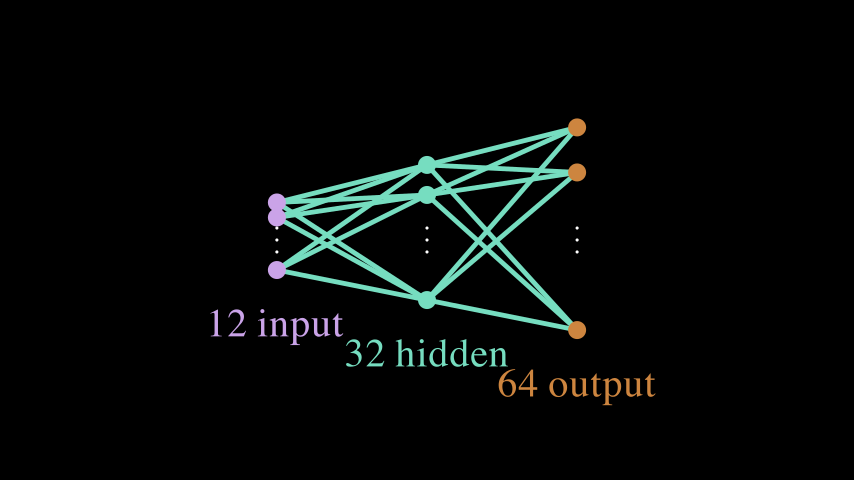

In [266]:
%%manim -ql -v CRITICAL FullyConnectedNN
# %%manim_slides -ql -v WARNING MyScene --manim-slides controls=true
# Choose to do regular manim or manim-slides by choosing the correct jupyter magic. Must be first line.

def myNN():
    # Define the layer positions
    input_layer_x = -2.5
    hidden_layer_x = 0
    output_layer_x = 2.5
    
    my_r = 0.15
    

    # Function to create a layer with 2 neurons at top, a \vdots, and 1 neuron at bottom
    def create_layer(x, y, clr, label, mydir = DOWN):
        top1 = Dot(point=UP * (2.5)*y,radius = my_r, color = clr)
        top2 = Dot(point=UP * 1.5 * y, radius = my_r, color = clr)
        middle = MathTex(r"\vdots").move_to(ORIGIN)
        bottom = Dot(point=DOWN * 2*y, radius = my_r, color = clr)
        layer = VGroup(top1, top2, middle, bottom).shift(x*RIGHT)
        text = Text(label, color = clr).next_to(layer, mydir * 2)
        return layer, text

    # Create layers
    input_layer, input_text = create_layer(input_layer_x, 0.25, state_color, "12 input")
    hidden_layer, hidden_text = create_layer(hidden_layer_x, 0.5, th_color, "32 hidden")
    output_layer, output_text = create_layer(output_layer_x, 0.75, action_color, "64 output")

    # Function to connect layers with more lines for a dense look
    def connect_layers(layer1, layer2, clr):
        lines = VGroup()
        for dot1 in [layer1[0], layer1[1], layer1[3]]:  # Top1, Top2, Bottom neurons
            for dot2 in [layer2[0], layer2[1], layer2[3]]:  # Top1, Top2, Bottom neurons
                lines.add(Line(dot1.get_center(), dot2.get_center(), 
                               color=clr, stroke_width=8).set_z_index(-1.0))
        return lines

    connections_1 = connect_layers(input_layer, hidden_layer, th_color)
    connections_2 = connect_layers(hidden_layer, output_layer, th_color)

    # Add elements to the scene
    out = VGroup()
    out.add(input_layer, input_text)
    out.add(hidden_layer, hidden_text)
    out.add(output_layer, output_text)
    out.add(connections_1, connections_2)

    return out
    

class FullyConnectedNN(Scene):
    
    def construct(self):
        self.add(myNN())


# Old Code

In [ ]:
# #my_temp = 100.0
# num_brain_steps = 20
# key = jax.random.PRNGKey(int(time.time()))
# key, subkey = random.split(key)  # Ensure reproducibility
# num_frames_per_brain = 25

# starting_word = random.randint(subkey, shape=(), minval=0, maxval=num_inits).item()
# print(f"Starting Word: {starting_word}")

# my_pumps, my_muscles = decode_pumps_muscles(starting_word)
# print(*[int(my_pumps[i]) for i in range(3)], *[int(my_muscles[i]) for i in range(3)])

# def create_plotting_episode(params,key,starting_word,num_frames_per_brain,my_temp=10):
#   '''Creates a bunch of episodes and returns the action, input and reward histories'''
#   action_history = jnp.zeros((num_brain_steps),dtype=int) #record which word is being used
#   my_points_history = jnp.zeros((num_frames_per_brain*num_brain_steps,3,2)) #record the inputs to the neural networks
#   my_masses_history = jnp.zeros((num_frames_per_brain*num_brain_steps,3))


#   key, subkey = random.split(key)
#   info_init = create_inits(subkey)

#   my_points = info_init[0][starting_word]
#   my_velocities = info_init[1][starting_word]
#   my_masses = info_init[2][starting_word]
#   my_pumps = info_init[3][starting_word]
#   my_muscles = info_init[4][starting_word]


#   for brain_step in range(num_brain_steps):



#     inputs = get_input(my_points, my_velocities, my_masses, my_pumps, my_muscles)


#     #Feed input into the brain and sample the muscles+pumps word
#     log_probs = forward(params, inputs)
#     key, subkey = jax.random.split(key)
#     sample = jax.random.categorical(subkey, log_probs/my_temp) # sample_action(subkey, log_probs, temperature=my_temp)
#     action_history = action_history.at[brain_step].set(sample)

#     #Decode word to get pump and muscle values, and then do physics simulation
#     my_pumps, my_muscles = decode_pumps_muscles(sample)

#     for frame in range(num_frames_per_brain):
#       my_points_history = my_points_history.at[frame + num_frames_per_brain*brain_step].set(my_points)

#       my_masses_history = my_masses_history.at[frame + num_frames_per_brain*brain_step].set(my_masses)

#       (my_points, my_velocities, my_masses, my_pumps, my_muscles) = jax.lax.fori_loop(0, num_physics_per_brain_step//num_frames_per_brain, triangle_update, (my_points, my_velocities, my_masses, my_pumps, my_muscles))


#   return action_history, my_points_history, my_masses_history

# action_history, my_points_history, my_masses_history = create_plotting_episode(params, subkey, starting_word, num_frames_per_brain, my_temp)


# # Set up the figure and axis for the animation
# fig, ax = plt.subplots()
# sc = ax.scatter([], [], s=[], c=[], cmap="coolwarm", edgecolors="k", vmin=0, vmax=1)
# lines = [ax.plot([], [], lw=3, alpha=0.8)[0] for _ in range(3)]  # One for each edge

# ax.set_xlim(-5, 10)
# ax.set_ylim(-5, 5)

# def update_frame(i):
#     global key, my_points, my_velocities, my_masses, my_pumps, my_muscles
#     #print(i)
#     if i % num_frames_per_brain == 0:

#       plt.title(f"Iteration: {i//num_frames_per_brain}")
#       sample = action_history[i//num_frames_per_brain]
#       print(i//num_frames_per_brain, sample)
#       my_pumps, my_muscles = decode_pumps_muscles(sample)
#       print(*[int(my_pumps[i]) for i in range(3)], *[int(my_muscles[i]) for i in range(3)])

#     my_points = my_points_history[i]
#     my_masses = my_masses_history[i]
#     # Extract x and y coordinates of vertices
#     x, y = my_points[:, 0], my_points[:, 1]

#     # Update vertex sizes (proportional to mass)
#     sizes = jnp.sqrt(my_masses)*50  # Scale appropriately for visibility

#     # Update vertex colors (based on my_pumps)
#     vertex_colors = my_pumps

#     # Update edges
#     for j, (p1, p2) in enumerate([(0, 1), (0,2), (1, 2)]):
#         lines[j].set_data([x[p1], x[p2]], [y[p1], y[p2]])

#         # Set edge color based on my_muscles
#         color_value = 1.0*my_muscles[j]
#         lines[j].set_color(plt.cm.coolwarm(color_value))  # Apply colormap

#     # Update scatter plot for vertices
#     sc.set_offsets(my_points)
#     sc.set_sizes(sizes)
#     sc.set_array(vertex_colors)  # Apply colormap to vertices

# # Create the animation using FuncAnimation
# ani = FuncAnimation(fig, update_frame, frames=num_brain_steps*num_frames_per_brain, interval=30, blit=False)

# # Display the animation in Google Colab using HTML
# HTML(ani.to_html5_video())

In [ ]:
# num_iters = 1000
# final_reward = np.zeros(num_iters)
# for iter in tqdm(range(num_iters)):
#   key,subkey = jax.random.split(key)
#   # Create episodes
#   input_history, action_history, reward_history = create_episodes(params,subkey)
#   final_reward[iter] = jnp.mean(reward_history[-1])
#   if (iter+1) % 100 == 0:
#     print(f"{iter=}, Avg:{np.mean(final_reward[iter+1-100:iter+1]):.2f}, SD:{np.std(final_reward[iter+1-100:iter+1]):.2f}")

#   # Flatten episodes
#   f_input_history = input_history.reshape((num_brain_steps,batch_size*num_inits,input_size))
#   f_action_history = action_history.reshape((num_brain_steps,batch_size*num_inits))
#   f_reward_history = reward_history.reshape((num_brain_steps,batch_size*num_inits))

#   # Accumulate gradients
#   accumulated_grads = None

#   for t in range(num_brain_steps):
#     # Compute the gradient at time step t
#     if t==0:
#       my_return = f_reward_history[-1] - 0
#     else:
#       my_return = f_reward_history[-1] - f_reward_history[t]
#     loss_gradient = loss_gradient_fn(params, f_input_history[t], f_action_history[t], my_return)

#     # Accumulate gradients over time steps
#     if accumulated_grads is None:
#         accumulated_grads = loss_gradient  # First step: Initialize
#     else:
#         accumulated_grads = jax.tree_util.tree_map(lambda a, b: a + b, accumulated_grads, loss_gradient)  # Sum gradients (need weird function cuz its a tuple)

#   accumulated_grads = jax.tree_util.tree_map(lambda g: g / num_brain_steps, accumulated_grads)

#   # Apply a **single** optimizer update after accumulating gradients
#   updates, new_optimizer_state = optimizer.update(accumulated_grads, optimizer_state)
#   params = optax.apply_updates(params, updates)

In [ ]:
# # Init conditions
# my_muscles = 0.0*jnp.ones(3)
# my_pumps = jnp.array([1.0,1.0,0.0])
# my_temp = 50.0

# batch_size = 40_000

# # Initialize simulation data
# my_points = my_points_init
# my_velocities = my_velocities_init
# my_masses = my_masses_init


# num_training_iters = 10000

# #gamma = 0.8 #0.99  # Discount factor


# accumulated_grads = None


# avg_distances = np.zeros((num_training_iters))

# std_distances = np.zeros((num_training_iters))

# key = jax.random.PRNGKey(int(time.time()))
# r = (L_min + L_max)/2.0
# key, subkey = random.split(key)  # Ensure reproducibility
# a0 = random.uniform(subkey, shape=(num_training_iters,), minval=0.5*jnp.pi/3.0, maxval= 1.5*jnp.pi/3.0)
# key, subkey = random.split(key)  # Ensure reproducibility
# a1 = random.uniform(subkey, shape=(num_training_iters,), minval=2.5*jnp.pi/3.0, maxval= 3.5*jnp.pi/3.0)
# key, subkey = random.split(key)  # Ensure reproducibility
# a2 = random.uniform(subkey, shape=(num_training_iters,), minval=4.5*jnp.pi/3.0, maxval= 5.5*jnp.pi/3.0)

# # Compute the corresponding points on the unit circle
# x0, y0 = r * jnp.cos(a0), r * jnp.sin(a0)
# x1, y1 = r * jnp.cos(a1), r * jnp.sin(a1)
# x2, y2 = r * jnp.cos(a2), r * jnp.sin(a2)

# # Stack to get shape (num_training_iters, 3, 2)
# my_points_init = jnp.stack([jnp.stack([x0, y0], axis=-1),
#                             jnp.stack([x1, y1], axis=-1),
#                             jnp.stack([x2, y2], axis=-1)], axis=1)




# for iters in tqdm(range(num_training_iters)):

#     # Replicate the initial state across the batch dimension


#   #as = jnp.array([a0, a1, a2])  # Ensure as is (3,)
#   #radii = jnp.full((3,), r)  # Ensure r is (3,)

#   #my_points_init = jnp.stack([radii * jnp.cos(as), radii * jnp.sin(as)], axis=-1)



#   #my_points_init = jnp.array([[-1.0,-1.0],[1.0,-1.0],[0.0,1.0]])

#   my_points = jnp.tile(my_points_init[iters], (batch_size, 1, 1))  # Shape: (batch_size, 3, 2)
#   my_velocities = jnp.tile(my_velocities_init, (batch_size, 1, 1))  # Shape: (batch_size, 3, 2)
#   my_masses = jnp.tile(my_masses_init, (batch_size, 1))  # Shape: (batch_size, 3)


#   action_history = np.zeros((num_brain_steps,batch_size),dtype=int)
#   input_history = np.zeros((num_brain_steps,batch_size,input_size))
#   #reward_history = np.zeros((num_brain_steps,batch_size)) #the rewards will be based on this history
#   log_action_taken_probs_history = np.zeros((num_brain_steps,batch_size)) #the log probability of the action we actually took

#   for brain_step in range(num_brain_steps):

#     #Create input into the brain
#     #inputs = jnp.concatenate([lengths(my_points), my_masses],axis=-1)

#     inputs = jnp.concatenate([normalize_points(my_points)[...,0],normalize_points(my_points)[...,1],lengths(my_points), my_masses],axis=-1)
#     state_history[brain_step] = inputs

#     #Feed input into the brain to get muscles+pumps word
#     logits = forward(params, inputs)
#     #print(jnp.shape(scaled_logits))
#     key, subkey = jax.random.split(key)
#     #sample, log_prob = sample_action_and_log_prob(key, logits, temperature=my_temp)
#     sample = sample_action(subkey, logits, temperature=my_temp)

#     action_history[brain_step] = sample
#     #log_action_taken_probs_history[brain_step] = log_prob

#     #Decode word to get pump and muscle values, and then do physics simulation
#     my_pumps, my_muscles = decode_pumps_muscles(sample)
#     #print(sample)
#     #centroid_before = compute_centroid_x(my_points)

#     (my_points, my_velocities, my_masses, my_pumps, my_muscles) = jax.lax.fori_loop(0, num_physics_per_brain_step, triangle_update, (my_points, my_velocities, my_masses, my_pumps, my_muscles))

#     #print(my_points[0,0,0])


#     #centroid_after = compute_centroid_x(my_points)
#     #reward_history[brain_step] = centroid_after - centroid_before

#   eps = 1e-8  # Small constant to prevent division by zero
#   #reward_history = (reward_history - np.mean(reward_history, axis=-1, keepdims=True)) / (np.std(reward_history, axis=-1, keepdims=True) + eps)

#   final_rewards =  2*compute_centroid_x(my_points) - jnp.abs(compute_centroid_y(my_points))
#   avg_distances[iters] = jnp.mean(final_rewards)
#   std_distances[iters] = jnp.std(final_rewards)
#   final_rewards = (final_rewards - avg_distances[iters]) / (std_distances[iters] + eps)

#   #reward_history[-1] = final_rewards

#   # Perform an update
#   #for k in range(num_updates_per_sample):
#   #  params, optimizer_state, loss = reinforce_update(
#   #      params, action_history, state_history, reward_history, #log_action_taken_probs_history, gamma, optimizer_state, optimizer.update
#   #  )




#   #for t in range(num_brain_steps):
#   #  loss_gradient = loss_gradient_fn(params, inputs, action_history[t, :], final_rewards)

#   #  updates, new_optimizer_state = optimizer.update(loss_gradient, optimizer_state)
#   #  params = optax.apply_updates(params, updates)
#     #updates, new_optimizer_state = optimizer.update(grads, optimizer_state)


#     # Compute log probabilities correctly
#   def log_probs(params, inputs, actions):
#       logits = forward(params, inputs)  # Shape: (batch_size, num_actions)
#       log_probs = jax.nn.log_softmax(logits, axis=-1)  # Shape: (batch_size, num_actions)
#       return log_probs[jnp.arange(actions.shape[0]), actions]  # Correct batch-wise indexing

#   # Compute policy gradient loss (negative log probs * reward-to-go)
#   def policy_loss(params, inputs, actions, returns):
#       log_action_probs = log_probs(params, inputs, actions)  # Shape: (batch_size,)
#       return -jnp.mean(log_action_probs * returns)  # Scalar loss

#   # Compute gradients
#   loss_gradient_fn = jax.grad(policy_loss)

#   accumulated_grads = None
#   for t in range(num_brain_steps):
#     # Compute the gradient at time step t
#     loss_gradient = loss_gradient_fn(params, inputs, action_history[t, :], final_rewards)

#     # Accumulate gradients over time steps
#     if accumulated_grads is None:
#         accumulated_grads = loss_gradient  # First step: Initialize
#     else:
#         accumulated_grads = jax.tree_util.tree_map(lambda a, b: a + b, accumulated_grads, loss_gradient)  # Sum gradients

#   # Normalize the accumulated gradients (optional, but often useful)
#   num_steps = num_brain_steps
#   accumulated_grads = jax.tree_util.tree_map(lambda g: g / num_steps, accumulated_grads)

#   # Apply a **single** optimizer update after accumulating gradients
#   updates, new_optimizer_state = optimizer.update(accumulated_grads, optimizer_state)
#   params = optax.apply_updates(params, updates)

#   # Update the model parameters
#   #new_params = optax.apply_updates(params, updates)

#   #avg_distances[iters] = jnp.mean(final_rewards)
#   interval = 100
#   if (iters+1) % interval == 0:
#     print(f"Iter: {iters}, Centroid Avg: {np.mean(avg_distances[iters+1-interval:iters+1]):.2f}, Centroid Std: {np.mean(std_distances[iters+1-interval:iters+1]):.2f}"  )


In [ ]:
#OLD CODE/COMMENTS
  #TRAPEZOID RULE TIMESTEP TO UPDATE KINEMATICS

  #masses at the halfway point
  #half_delta_m = 0.5*dt*mass_rates
  #masses += half_delta_m


  # Compute accelerations from forces and masses (F = ma -> a = F/m)
  #accelerations = forces / masses[..., None]  # Shape: (3, 2)

  #velocity at halfway point
  #half_delta_v = 0.5*dt*accelerations
  #velocities += half_delta_v

  #positions += velocities * dt #update posiitons using the halfway velocity

  #do the SECOND half of the time step for masses and velocities
  #masses += half_delta_m
  #velocities += half_delta_v

  #positions, velocities = trapezoid_timestep(positions, velocities, forces, masses, dt)

  #pumps =  UPDATE BASED ON NEURAL NETWORK
  #muscles = UPDATE BAASED ON NEURAL NETWORK


  #=== FANCIER WAY OF DOING FRICTION ===
  # This commented out block has a slightly fancier way of doing friciton where
  # the static friction opposes the force if the object is static but the force exceeds the max static force
  # I'm going to stick to the slightly simplified way which is like the original simulation.
  ##
  # Static friction force: balance external forces, but limited by the maximum static friction
  #static_friction_forces = jnp.where(
  #    force_magnitudes[..., None] <= static_friction_max[..., None],
  #    -forces,  # Fully balances the external force if within static friction limits
  #    -static_friction_max[..., None] * force_directions  # Maximum static friction force
  #)  # Shape: (batch_size, 3, 2)

  # Kinetic friction force: acts in the opposite direction of velocity
  #kinetic_friction_forces = -kinetic_friction_magnitudes[..., None] * velocity_directions  # Shape: (batch_size, 3, 2)

  # Combine static and kinetic friction forces
  #friction_forces = jnp.where(is_static[..., None], static_friction_forces, kinetic_friction_forces)

  # Compute the net forces: external forces + friction forces
  #net_forces = forces + friction_forces  # Shape: (batch_size, 3, 2)
  # Normalize the external forces for direction
  #force_directions = jnp.where(
  #    force_magnitudes[..., None] > epsilon,
  #    forces / force_magnitudes[..., None],
  #    0.0
  #)  # Shape: (batch_size, 3, 2)

  ##
  #Lets ignore pump forces for now...slightly annoying.
  # Compute pump forces based on conservation of momentum law :
  # F_pump = (dm/dt) * (fluid_velocity) = (dm/dt)*(leg_length / dt)
  #p_force_01 = mass_rates[...,0]*pump_v* dir_01  # Shape: (batch_size, 2)
  #p_force_02 = mass_rates[...,1]*pump_v* dir_02  # Shape: (batch_size, 2)
  #p_force_12 = mass_rates[...,2]*pump_v* dir_12  # Shape: (batch_size, 2)


In [ ]:
# def compute_returns(rewards, gamma):
#     """Compute the discounted rewards-to-go for each timestep in the trajectory."""
#     returns = jnp.zeros_like(rewards)
#     running_sum = 0
#     for t in reversed(range(rewards.shape[0])):
#         running_sum = rewards[t] + gamma * running_sum
#         returns = returns.at[t].set(running_sum)
#     return returns

# def reinforce_update2(params, action_history, state_history, reward_history, gamma, optimizer_state, opt_update):
#     """Update the parameters using the REINFORCE algorithm"""


#     # Define a function to calculate the policy loss
#     def policy_loss2(params, action_history, state_history, returns):
#         # Compute the logits (output of the network)
#         logits = forward(params, state_history)

#         # Convert logits to action probabilities (softmax)
#         action_probs = jax.nn.softmax(logits)

#         # Gather the action probabilities for the taken actions
#         action_taken_probs = action_probs[jnp.arange(action_history.shape[0]), action_history]

#         # Compute the log-probabilities of the taken actions
#         log_action_taken_probs = jnp.log(action_taken_probs)

#         # Compute the loss (REINFORCE objective)
#         loss = -jnp.sum(log_action_taken_probs * returns)

#         return loss, action_probs

#     # Initialize the gradients
#     grad_fn = jax.value_and_grad(policy_loss2, has_aux=True)

#     # Calculate the returns (reward-to-go) for each timestep
#     returns = compute_returns(reward_history, gamma)


#     # Compute the gradient of the loss function
#     loss, action_probs = grad_fn(params, action_history, state_history, returns)

#     # Apply the optimizer step (gradient update)
#     updates, new_optimizer_state = opt_update(loss, optimizer_state)

#     # Update the parameters
#     new_params = optax.apply_updates(params, updates)

#     return new_params, new_optimizer_state, loss


# def reinforce_update(params, action_history, state_history, reward_history, log_action_taken_probs_history, gamma, optimizer_state, opt_update):
#     """Update the parameters using the REINFORCE algorithm, given the log action probabilities."""

#     # Calculate the returns (reward-to-go) for each timestep
#     returns = compute_returns(reward_history, gamma)

#     # Define a function to compute the REINFORCE loss
#     def policy_loss(params, action_history, state_history, log_action_taken_probs_history, returns):
#         # The loss function is the negative sum of log-probabilities weighted by returns
#         loss = -jnp.sum(log_action_taken_probs_history * returns) / returns.shape[1]  # Normalize by batch size
#         return loss

#     # Compute the gradient of the loss function with respect to the parameters
#     grad_fn = jax.value_and_grad(policy_loss)

#     # Corrected: grad_fn returns BOTH loss and gradients
#     loss, grads = grad_fn(params, action_history, state_history, log_action_taken_probs_history, returns)

#     # Apply the optimizer step (gradient update)
#     updates, new_optimizer_state = opt_update(grads, optimizer_state)

#     # Update the model parameters
#     new_params = optax.apply_updates(params, updates)

#     return new_params, new_optimizer_state, loss